# TP sur la regression Ridge 

In [1]:
# import des librairies
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

## Partie 1: Donnees synthetiques

On genere tout d'abord un ensemble des points qui viennent d'une fonction-cible de type sinusoide, auquel on ajoute un bruit gaussien. 

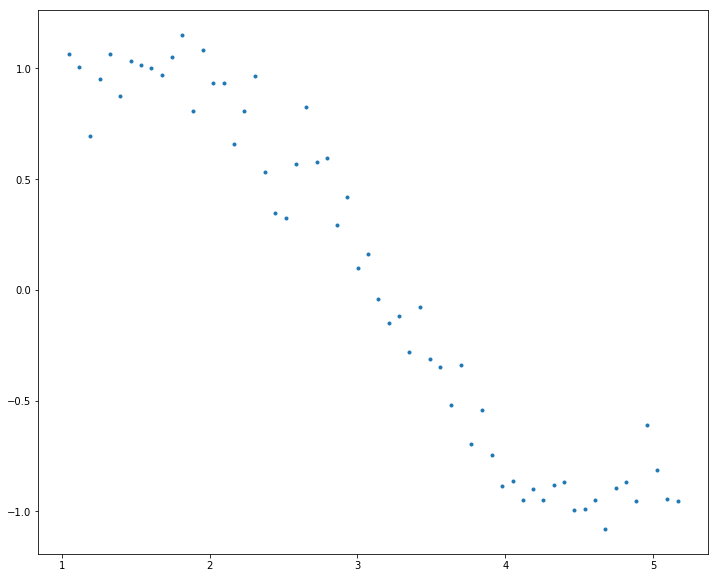

In [2]:
# Definition d'un input array avec angles de 60 a 300 degrees convertis en radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  # seed pour la reproductibilite
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

On essaie a present d'estimer cette fonction avec differentes **regressions polynomiales**, dont les polynomes sont de degres 1 a 15. Plus specifiquement, on transforme les donnees initiales univariables, en ajoutant une nouvelle variable/colonne $X_i$, $i\in\{2,3,\ldots,15\}$ correspondant a chacun des nouveaux polynomes:

In [3]:
for i in range(2,16):  # deg 1 deja present
    colname = 'x_%d'%i      # nouvelle variable
    data[colname] = data['x']**i
print(data.head())

          x         y       x_2       x_3       x_4       x_5       x_6  \
0  1.047198  1.065763  1.096623  1.148381  1.202581  1.259340  1.318778   
1  1.117011  1.006086  1.247713  1.393709  1.556788  1.738948  1.942424   
2  1.186824  0.695374  1.408551  1.671702  1.984016  2.354677  2.794587   
3  1.256637  0.949799  1.579137  1.984402  2.493673  3.133642  3.937850   
4  1.326450  1.063496  1.759470  2.333850  3.095735  4.106339  5.446854   

        x_7       x_8        x_9       x_10       x_11       x_12       x_13  \
0  1.381021  1.446202   1.514459   1.585938   1.660790   1.739176   1.821260   
1  2.169709  2.423588   2.707173   3.023942   3.377775   3.773011   4.214494   
2  3.316683  3.936319   4.671717   5.544505   6.580351   7.809718   9.268760   
3  4.948448  6.218404   7.814277   9.819710  12.339811  15.506664  19.486248   
4  7.224981  9.583578  12.712139  16.862020  22.366630  29.668222  39.353420   

        x_14       x_15  
0   1.907219   1.997235  
1   4.707635   5

On est maintenant en mesure d'estimer 15 regressions lineaires ordinaires differentes, en augmentant progressivement le degre maximal du polynome. Par exemple, la 7eme regression etimera 8 parametres correspondant a $x, x_2, \ldots, x_7$ plus un parametre pour l'intersection. Pour ce faire, on utilisera l'implementation fournie dans `sklearn`. 

En vue de rester concis, on definit une fonction qui estime chacune de ces regressions en memorisant au passage leur erreur quadratique au carre moyenne (MSE), et les valeurs des coefficients estimees. 

In [4]:
from sklearn.linear_model import LinearRegression
def linear_regression(data, power, models_to_plot):
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    # estimation
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    # plot
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Degre <= %d'%power)
    
    # retour du resultat en format: MSE, intersection, coef
    mse = 1./data.shape[0]*sum((y_pred-data['y'])**2)
    ret = [mse]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

On estime les 15 modeles en stockant les resulats dans une matrice. En meme temps, on visualise les fonctions apprises par les differents modeles: 

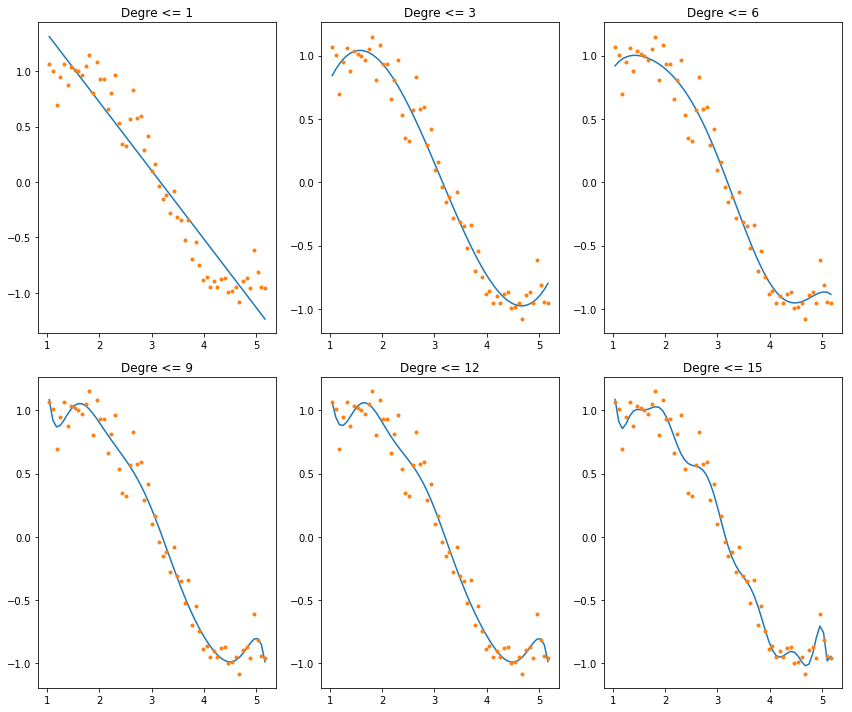

In [5]:
# Initialisation d'un dataframe pour stocker les resultats des estimations
col = ['mse','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

# On restreint les degres pour lesquels on va produire un plot
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

# estimation iteree
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

Comme on aurait pu s'y attendre, les modeles les plus complexes (cad d'ordre superieur) soient capables de mieux coller aux donnees, voire de les "overfitter". Ce qui se verifie aussi au niveau des taux d'erreur empiriques:

In [6]:
coef_matrix_simple['mse']

model_pow_1     0.0546719
model_pow_2     0.0546113
model_pow_3     0.0183892
model_pow_4     0.0179763
model_pow_5     0.0169762
model_pow_6     0.0165012
model_pow_7     0.0154711
model_pow_8     0.0152935
model_pow_9     0.0145823
model_pow_10    0.0145763
model_pow_11    0.0145328
model_pow_12    0.0145232
model_pow_13    0.0142793
model_pow_14    0.0131143
model_pow_15    0.0117471
Name: mse, dtype: object

**Question:**
Visualiser les coefficients: que remarque-t-on quant a leur valeur en fonction du degre du polynome?   

In [7]:
# format d'affichage scientifique
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

mse intercept coef_x_1 coef_x_2 coef_x_3 coef_x_4 coef_x_5  \
model_pow_1  0.055         2    -0.62      NaN      NaN      NaN      NaN   
model_pow_2  0.055       1.9    -0.58   -0.006      NaN      NaN      NaN   
model_pow_3  0.018      -1.1        3     -1.3     0.14      NaN      NaN   
model_pow_4  0.018     -0.27      1.7    -0.53   -0.036    0.014      NaN   
model_pow_5  0.017         3     -5.1      4.7     -1.9     0.33   -0.021   
model_pow_6  0.017      -2.8      9.5     -9.7      5.2     -1.6     0.23   
model_pow_7  0.015        19      -56       69      -45       17     -3.5   
model_pow_8  0.015        43 -1.4e+02  1.8e+02 -1.3e+02       58      -15   
model_pow_9  0.015   1.7e+02 -6.1e+02  9.6e+02 -8.5e+02  4.6e+02 -1.6e+02   
model_pow_10 0.015   1.4e+02 -4.9e+02  7.3e+02   -6e+02  2.9e+02      -87   
model_pow_11 0.015       -75  5.1e+02 -1.3e+03  1.9e+03 -1.6e+03  9.1e+02   
model_pow_12 0.015  -3.4e+02  1.9e+03 -4.4e+03    6e+03 -5.2e+03  3.1e+03   
model_pow_13 0.014   3.2e+03 -1.8e+04  4.5e+04 -6.7e+04  6.6e+04 -4.6e+04   
model_pow_14 0.013   2.4e+04 -1.4e+05  3.8e+05 -6.1e+05  6.6e+05   -5e+05   
model_pow_15 0.012  -3.6e+04  2.4e+05 -7.5e+05  1.4e+06 -1.7e+06  1.5e+06   

             coef_x_6 coef_x_7 coef_x_8 coef_x_9 coef_x_10 coef_x_11  \
model_pow_1       NaN      NaN      NaN      NaN       NaN       NaN   
model_pow_2       NaN      NaN      NaN      NaN       NaN       NaN   
model_pow_3       NaN      NaN      NaN      NaN       NaN       NaN   
model_pow_4       NaN      NaN      NaN      NaN       NaN       NaN   
model_pow_5       NaN      NaN      NaN      NaN       NaN       NaN   
model_pow_6    -0.014      NaN      NaN      NaN       NaN       NaN   
model_pow_7       0.4   -0.019      NaN      NaN       NaN       NaN   
model_pow_8       2.4    -0.21   0.0077      NaN       NaN       NaN   
model_pow_9        37     -5.2     0.42   -0.015       NaN       NaN   
model_pow_10       15    -0.81    -0.14    0.026   -0.0013       NaN   
model_pow_11 -3.5e+02       91      -16      1.8     -0.12    0.0034   
model_pow_12 -1.3e+03  3.8e+02      -80       12      -1.1     0.062   
model_pow_13  2.3e+04 -8.5e+03  2.3e+03 -4.5e+02        62      -5.7   
model_pow_14  2.8e+05 -1.2e+05  3.7e+04 -8.5e+03   1.5e+03  -1.8e+02   
model_pow_15   -1e+06    5e+05 -1.9e+05  5.4e+04  -1.2e+04   1.9e+03   

             coef_x_12 coef_x_13 coef_x_14 coef_x_15  
model_pow_1        NaN       NaN       NaN       NaN  
model_pow_2        NaN       NaN       NaN       NaN  
model_pow_3        NaN       NaN       NaN       NaN  
model_pow_4        NaN       NaN       NaN       NaN  
model_pow_5        NaN       NaN       NaN       NaN  
model_pow_6        NaN       NaN       NaN       NaN  
model_pow_7        NaN       NaN       NaN       NaN  
model_pow_8        NaN       NaN       NaN       NaN  
model_pow_9        NaN       NaN       NaN       NaN  
model_pow_10       NaN       NaN       NaN       NaN  
model_pow_11       NaN       NaN       NaN       NaN  
model_pow_12   -0.0016       NaN       NaN       NaN  
model_pow_13      0.31   -0.0078       NaN       NaN  
model_pow_14        15     -0.73     0.017       NaN  
model_pow_15  -2.2e+02        17     -0.81     0.018

On va maintenant re-estimer nos modeles, mais en penalisant les valeurs de coefficient trop importantes via une norme $l_2$. C'est ce qu'on appelle la **regression Ridge**. Pour rappel, la fonction objective associee a la regression Ridge est comme suit:
$$
\text{argmin}_{\textbf{w}\in R^d} X^{\top}\textbf{w} + \alpha ||\textbf{w}||^2_2
$$
ou X represente la matrice des donnees (de taille $N\times d$), $||\cdot||_2$ est la norme euclidienne, et $\alpha \geq 0$ le parametre de regularisation qui controle la valeur des coefficients. Plus $\alpha$ est petit, moins le modele est contraint: dans le cas ou $alpha = 0$, on retrouve le modele lineaire ordinaire. Plus $\alpha$ est grand, plus le modele est contraint et les coefficients tendent vers $0$. 


**Question:** Ecrire une fonction, similaire a celle definie plus haut par la regression lineaire ordinaire, qui permet d'estimer differents modeles de regression Ridge correspondant a differentes valeur de $\alpha$. On supposera que toutes les variables $x$, $x_1$, \ldots, $x_15$ sont dans le modele. Indice: utiliser `sklearn.linear_model.Ridge`.  

In [8]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, powalpha, models_to_plot={}):    
    # estimation
    ridge = Ridge(normalize=True, alpha=pow(alpha, powalpha))
    ridge.fit(data[predictors],data['y'])
    y_pred = ridge.predict(data[predictors])
    
    # plot
    if powalpha in models_to_plot:
        plt.subplot(models_to_plot[powalpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Alpha = %d^%f'%(alpha, powalpha))
    
    # retour du resultat en format: MSE, intersection, coef
    mse = 1./data.shape[0]*sum((y_pred-data['y'])**2)
    ret = [mse]
    ret.extend([ridge.intercept_])
    ret.extend(ridge.coef_)
    return ret

On estimera ensuite $10$ modeles, correspondant aux valeurs suivantes de $\alpha$: $[10^{-10}, 10^{-8}, 10^{-6}, 10^{-4}, 10^{-3},10^{-2}, 10^{-1}, 10^0, 10^{.5}, 10^1]$. 

**Question:**
Visualiser les differents fonctions estimees et commenter l'effet de differentes valeurs de $\alpha$. 

In [9]:
alphas = [-1000, -100, -10, -8, -6, -4, -3, -2, -1, 0, 0.5, 1, 10]


# Initialisation d'un dataframe pour stocker les resultats des estimations
col = ['mse','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_alpha_%f'%pow(10, i) for i in alphas]
coef_matrix_simple_ridge = pd.DataFrame(index=ind, columns=col)

E:\Users\hqrd\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.748588253849837e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)


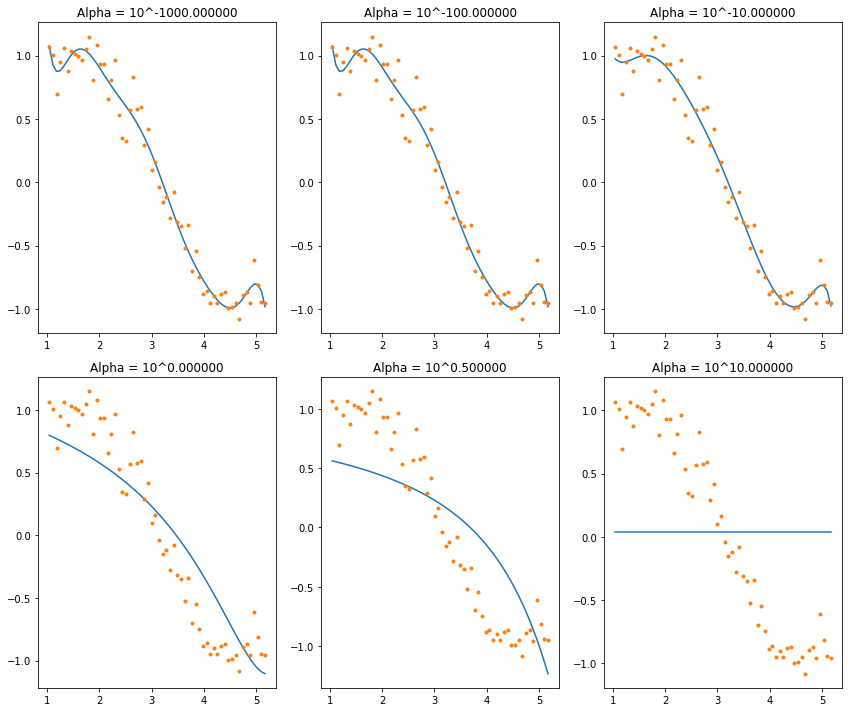

In [10]:
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,15+1)])

# On restreint les puissances pour lesquelles on va produire un plot
models_to_plot = {-1000:231,-100:232, -10:233, 0:234, 1/2:235, 10:236}

# estimation iteree
x = 0
for i in alphas:
    coef_matrix_simple_ridge.iloc[x,0:17] = ridge_regression(data, predictors=predictors, alpha=10, powalpha=i, models_to_plot=models_to_plot)
    x += 1

# Réponse :
# Au plus alpha diminue, au plus le modèle est complexe. De ce fait, il est possible que celui-ci modélise le bruit : on parle d'"overfitte" .
# Plus on l'augmente, plus les contraintes sont fortes.

**Question:** Visualiser les coefficients et commenter a nouveau l'effet de differentes valeurs de $\alpha$. 

In [11]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple_ridge

# Réponse :
# Au moins l'espace d'hypothèse est contraint, au plus l'erreur sur les données d'entrainements diminue

mse intercept coef_x_1 coef_x_2 coef_x_3  \
model_alpha_0.000000           0.015   1.1e+02 -3.9e+02  5.7e+02 -4.7e+02   
model_alpha_0.000000           0.015   1.1e+02 -3.9e+02  5.7e+02 -4.7e+02   
model_alpha_0.000000           0.015        11      -29       31      -15   
model_alpha_0.000000           0.016       1.3     -1.5      1.7    -0.68   
model_alpha_0.000001           0.016       0.2        1    -0.26   -0.046   
model_alpha_0.000100           0.016      0.56     0.55    -0.13   -0.026   
model_alpha_0.001000           0.017      0.82     0.31   -0.087    -0.02   
model_alpha_0.010000           0.024       1.3   -0.088   -0.052    -0.01   
model_alpha_0.100000           0.033       1.4    -0.22   -0.034  -0.0052   
model_alpha_1.000000           0.094      0.97    -0.14   -0.019   -0.003   
model_alpha_3.162278            0.19      0.66   -0.078   -0.011  -0.0018   
model_alpha_10.000000            0.3       0.4   -0.037  -0.0055 -0.00095   
model_alpha_10000000000.000000  0.62     0.038 -6.2e-11 -9.7e-12 -1.8e-12   

                               coef_x_4 coef_x_5 coef_x_6 coef_x_7 coef_x_8  \
model_alpha_0.000000            2.5e+02      -92       28     -6.6     0.94   
model_alpha_0.000000            2.5e+02      -92       28     -6.6     0.94   
model_alpha_0.000000                2.9     0.17   -0.091   -0.011    0.002   
model_alpha_0.000000              0.039    0.016  0.00016 -0.00036 -5.4e-05   
model_alpha_0.000001             0.0022   0.0014  0.00015 -1.5e-05 -8.3e-06   
model_alpha_0.000100            -0.0028 -0.00011  4.1e-05  1.5e-05  3.7e-06   
model_alpha_0.001000            -0.0028 -0.00022  1.8e-05  1.2e-05  3.4e-06   
model_alpha_0.010000            -0.0014 -0.00013  7.2e-07  4.1e-06  1.3e-06   
model_alpha_0.100000           -0.00073 -9.1e-05 -8.8e-06 -2.8e-07  1.6e-07   
model_alpha_1.000000           -0.00047   -7e-05 -9.9e-06 -1.3e-06 -1.4e-07   
model_alpha_3.162278            -0.0003 -4.9e-05 -7.9e-06 -1.2e-06 -1.9e-07   
model_alpha_10.000000          -0.00017   -3e-05 -5.2e-06 -9.2e-07 -1.6e-07   
model_alpha_10000000000.000000 -3.3e-13 -6.3e-14 -1.2e-14 -2.2e-15 -4.3e-16   

                               coef_x_9 coef_x_10 coef_x_11 coef_x_12  \
model_alpha_0.000000              0.061    -0.064     0.015   -0.0022   
model_alpha_0.000000              0.061    -0.064     0.015   -0.0022   
model_alpha_0.000000            0.00064   2.4e-05    -2e-05  -4.2e-06   
model_alpha_0.000000           -2.9e-07   1.1e-06   1.9e-07     2e-08   
model_alpha_0.000001           -1.4e-06  -3.7e-08   5.8e-08   2.1e-08   
model_alpha_0.000100            7.4e-07   1.3e-07   1.9e-08   1.9e-09   
model_alpha_0.001000            7.3e-07   1.3e-07   1.9e-08   1.7e-09   
model_alpha_0.010000              3e-07   5.6e-08     9e-09   1.1e-09   
model_alpha_0.100000            6.3e-08   1.6e-08   3.6e-09   7.4e-10   
model_alpha_1.000000           -9.3e-09   1.3e-09   7.8e-10   2.4e-10   
model_alpha_3.162278           -2.9e-08  -4.2e-09  -5.5e-10  -6.3e-11   
model_alpha_10.000000          -2.9e-08  -5.1e-09  -9.1e-10  -1.6e-10   
model_alpha_10000000000.000000 -8.1e-17  -1.5e-17  -2.9e-18  -5.6e-19   

                               coef_x_13 coef_x_14 coef_x_15  
model_alpha_0.000000             0.00022  -1.5e-05   5.1e-07  
model_alpha_0.000000             0.00022  -1.5e-05   5.1e-07  
model_alpha_0.000000             2.2e-07   2.3e-07  -2.3e-08  
model_alpha_0.000000             3.9e-09   8.2e-10  -4.6e-10  
model_alpha_0.000001             4.1e-09   1.5e-10  -2.7e-10  
model_alpha_0.000100            -1.3e-10  -1.5e-10  -6.2e-11  
model_alpha_0.001000            -1.5e-10  -1.4e-10  -5.2e-11  
model_alpha_0.010000             4.3e-11  -3.1e-11  -1.5e-11  
model_alpha_0.100000             1.4e-10   2.6e-11   4.4e-12  
model_alpha_1.000000             6.2e-11   1.4e-11   3.2e-12  
model_alpha_3.162278            -4.7e-12   4.1e-13   3.1e-13  
model_alpha_10.000000           -2.9e-11  -5.1e-12  -9.1e-13  
model

## Partie 2: Donnees reelles et validation croisee pour estimer $\alpha$

Dans cette partie, on utilise la regression Ridge pour estimer des modeles de regression sur le jeu de donnees de `housing` utilisee lors du premier TP sur la regression lineaire. Pour estimer la valeur optimale du parametre de regularisation $\alpha$, on utilise la technique de la validation croisee. 

Pour rappel, le jeu de donnees `housing` est disponible a partir de l'url:

   https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

Ce jeu de donnees a deja ete charge sous la forme d'un dataframe avec pandas, qui a ete 
ensuite separe en une matrice X contenant les variables explicatives et un vecteur Y contenant la variable a expliquer (MEDV). Par ailleurs, X et Y ont ete aleatoirement divises en un jeu de donnees d'apprentissage (X_train et Y_train), qui serviront a estimer les parametres des modeles, et un jeu de test (X_test et Y_test) pour evaluer les performances du modele sur des donnees non vues a l'apprentissage. 2/3 des donnees sont utilisees pour l'apprentissage et 1/3 pour le test. 

In [67]:
import os
dir_path = "../TP4/"
data_path = os.path.join(dir_path, "housing.data")
names_path = os.path.join(dir_path, "housing.names")

boston_df = pd.read_table(data_path, sep="\s+", header=None)
boston_df.columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", \
                       "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]
#print(boston_df.head())

# separate data into X (explonatory variables) and Y (target)
X = boston_df.drop('MEDV', axis=1)
Y = boston_df['MEDV']

# split dataset into train/test
from sklearn import model_selection
#X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(X, Y, test_size = 0.33, random_state = 5)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size = 0.33, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(339, 13)
(167, 13)
(339,)
(167,)


On estime tout d'abord un modele de regression polynomiale de degre $3$ avec un la methode des moindres carres ordinaires, en calculant les MSE sur le `train` et sur le `test`:

In [68]:
from sklearn.preprocessing import PolynomialFeatures

# polynomial degree 3
poly3 = PolynomialFeatures(degree=3)
X_train_p3 = poly3.fit_transform(X_train)
X_test_p3 = poly3.fit_transform(X_test)

lm_p3 = LinearRegression(fit_intercept=True, 
                         normalize=True)
lm_p3.fit(X_train_p3, Y_train)
Y_hat_p3 = lm_p3.predict(X_test_p3)

Y_train_p3_hat = lm_p3.predict(X_train_p3)
print("Train MSE:", np.mean((Y_train_p3_hat-Y_train)**2) )
print("Test MSE:", np.mean((Y_hat_p3-Y_test)**2) )

#print(lm_p3.coef_)
print("# params:", len(lm_p3.coef_))

Train MSE: 9.320843397933396e-23
Test MSE: 7974.232235676336
# params: 560


**Question:** Estimer un modele de regression Ridge en selectionnant la meilleure valeur de $\alpha$ via une validation croisee avec $5$ "folds" sur l'ensemble de `train`. Indice: utiliser la classe `Kfold` du module `from sklearn.model_selection`. Attention a utiliser l'option `nomalize=True` lors du `fit`. 

Quelle est la "meilleure" valeur de $\alpha$ obtenue par validation croisee? Quelle est la MSE correspondate sur l'ensemble de `test`?  

In [72]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

X_train = np.array(X_train)
X_test  = np.array(X_test)
X_train = X_train_p3
X_test  = X_test_p3
Y_train = np.array(Y_train)
Y_test  = np.array(Y_test)

min_alpha = None
best_alpha = None
for i in alphas:
    mses = list()
    
    for train_index, test_index in kf.split(X_train):      
        ridge = Ridge(fit_intercept=True, normalize=True, alpha=pow(10, i))  
        X_train_sub, X_test_sub = X_train[train_index], X_train[test_index]
        Y_train_sub, Y_test_sub = Y_train[train_index], Y_train[test_index]
        
        ridge.fit(X_train_sub, Y_train_sub)
        y_test_hat = ridge.predict(X_test_sub)
        
#        y_train_hat= ridge.predict(X_train_sub)
#        print("Train MSE = ",np.mean((y_train_hat - Y_train_sub)**2))

        # retour du resultat en format: MSE, intersection, coef
        mse = np.mean((y_test_hat - Y_test_sub)**2)
        mses.append(mse)
        
    average_alpha = sum(mses) / len(mses)
    print("Average train MSE (on test split) for alpha =", i, " :", average_alpha )
    
    if min_alpha == None or average_alpha < min_alpha :
        min_alpha = average_alpha
        best_alpha = i


ridge = Ridge(normalize=True, alpha=pow(10, best_alpha))
ridge.fit(X_train, Y_train)
y_test_hat = ridge.predict(X_test)
mse = np.mean((y_test_hat - Y_test)**2)
print("\nAverage Test MSE for best alpha =", best_alpha, " :", mse)

E:\Users\hqrd\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.497832441879647e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
E:\Users\hqrd\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.443809882045461e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
E:\Users\hqrd\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.8562896220636245e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
E:\Users\hqrd\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Resu

Average train MSE (on test split) for alpha = -1000  : 3885.86876933
Average train MSE (on test split) for alpha = -100  : 3885.86876933
Average train MSE (on test split) for alpha = -10  : 3869.2869755
Average train MSE (on test split) for alpha = -8  : 2869.81422866
Average train MSE (on test split) for alpha = -6  : 262.332849015
Average train MSE (on test split) for alpha = -4  : 36.9787206977
Average train MSE (on test split) for alpha = -3  : 18.318338419
Average train MSE (on test split) for alpha = -2  : 15.1920842688
Average train MSE (on test split) for alpha = -1  : 14.9720832921
Average train MSE (on test split) for alpha = 0  : 18.7332420092
Average train MSE (on test split) for alpha = 0.5  : 21.8885199817
Average train MSE (on test split) for alpha = 1  : 26.317477852
Average train MSE (on test split) for alpha = 10  : 79.905966548

Average Test MSE for best alpha = -1  : 11.5058199406
